<a href="https://colab.research.google.com/github/sleptonium/demos/blob/main/BS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tour of Tensorflow with a Black Scholes pricing example




Demonstrating the baskic TensorFlow concepts using the [Black Scholes](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) pricing model as an example. 

What we'll cover. 
* Highlights of the BS Model
* Tensors
* Eager Mode vs the TensorFlow Graph
* A more complex model
  * Gaussian Copula model
  * Swap Pricing
* Devices & Performance
  * CPU - The machines Central Processing Unit. 
  * GPU - Graphical Processing Units
  * TPU - Custom Tensor Processing Units
  * QPU? - The Quantum Era?
* AAD Automatic Algebraic Differentiation
  * Concepts
  * Tape
  * Higher Order Differentiation. 
* Very Large Graphs
  * DIY
  * Managed Servcies
* KubeFlow, DataFlow, TFX
* Models
  * Keras and ML 
  * TensorFlow probability
  * Quant Finance in TF. 
* Advanced thoughts. 
  * TFX
  * XLA


The Black Scholes model is a key algorithm in Finance for procing derivatives. 

Take a call option with:

* Strike price K
* $\Delta t$ years until maturity. 

The payoff at maturity of this optiion is $ (S_T-K) $ where 

* $ S_T $ is the spot price of the underlying at maturity. 

Pricing this derivative at $ t=0 $ we can use the Black Scholes formula with following:

* $\sigma$ = volatility of the underlying 

* $S_0$  = Underlying price at t=0


$$
NPV = \Phi(d_1) S - \Phi(d_2)e^{-r \Delta t}K
$$

where

$ \Phi(x) $ = cumulative normal density function CDF. 

and

$$ 
d1 = \frac{ln( \frac SK )+ ({r+\frac{\sigma^2}{2} )}\Delta t }{\sigma \sqrt(\Delta t)}
$$

$$
d_2 = d_1 - \sigma \sqrt{\Delta t}
$$



In [1]:
import tensorflow as tf
import time 
import pandas as pd

SQRT_2 = 1.4142135623730952

@tf.function
def normal_cdf(x: tf.Tensor) -> tf.Tensor:
  """ Computes the CDF for the unit notmal distribution """
  x = tf.convert_to_tensor(x)
  return 0.5 + tf.math.erf(x/SQRT_2)/2

In [98]:

                        
@tf.function
def BS_Call(S, K, dt, vol, r):
    """Prices call option.
 
    Parameters
    ----------
    S   : float       Spot price at T0.
    K   : float       Strike price.
    dt  : float       Time to maturity.
    vol : float       Volatility.
    r   : float       Risk free rate.
 
    Returns
    -------
    npv : float                Net present value.
    """
    dt_sqrt = tf.sqrt(dt)
    phi = normal_cdf
  
    d1 = (tf.math.log(S / K) + (r + vol ** 2 / 2) * dt) / (vol * dt_sqrt)
    d2 = d1 - vol * dt_sqrt
    npv =  S * phi(d1) - K * tf.exp(-r * dt) * phi(d2)
    return npv



In [4]:
S    = tf.constant(5.,   dtype = tf.float32)
vol  = tf.constant(0.2,  dtype = tf.float32)
r    = tf.constant(0.01, dtype = tf.float32)
K    = tf.constant(5.5,  dtype = tf.float32)
dt   = tf.constant(0.5,  dtype = tf.float32)

npv = BS_Call(S, K, dt, vol, r)
npv.numpy()

0.116971254

In [7]:
S

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

In [14]:
S = tf.range(0,10., 1, dtype=tf.float32)
S

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)>

TensorShape([10])

In [16]:
npv = BS_Call(S, K, dt, vol, r)
npv

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.31524575e-06,
       3.07909772e-03, 1.16971135e-01, 6.53038502e-01, 1.54189348e+00,
       2.52847290e+00, 3.52748585e+00], dtype=float32)>

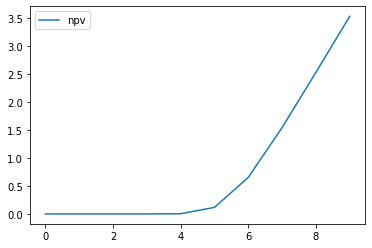

In [18]:
S = tf.range(0,10., 1, dtype=tf.float32)
npv = BS_Call(S, K, dt, vol, r)
import pandas as pd
price = pd.DataFrame(data=npv.numpy() , columns=['npv'])
price.plot()

In [19]:
price

,npv
0,0.000000
1,0.000000
2,0.000000
3,0.000001
4,0.003079
5,0.116971
6,0.653039
7,1.541893
8,2.528473
9,3.527486


In [23]:
dt = tf.range(0,10., 1, dtype=tf.float32)
dt = tf.expand_dims(dt, axis=-1)
dt

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [7.],
       [8.],
       [9.]], dtype=float32)>

In [22]:
npv = BS_Call(S, K, dt, vol, r)
npv

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 5.0000000e-01, 1.5000000e+00,
        2.5000000e+00, 3.5000000e+00],
       [0.0000000e+00, 0.0000000e+00, 8.2660620e-08, 3.2920437e-04,
        2.4734586e-02, 2.3050570e-01, 7.8557539e-01, 1.6162248e+00,
        2.5683990e+00, 3.5574145e+00],
       [0.0000000e+00, 0.0000000e+00, 5.2565709e-05, 7.8771710e-03,
        9.7771049e-02, 4.0920198e-01, 9.8994184e-01, 1.7750387e+00,
        2.6772194e+00, 3.6359949e+00],
       [0.0000000e+00, 1.4790749e-07, 7.5921463e-04, 2.7407810e-02,
        1.7994559e-01, 5.5448878e-01, 1.1543310e+00, 1.9226029e+00,
        2.7966890e+00, 3.7308536e+00],
       [0.0000000e+00, 3.1763957e-06, 3.1873211e-03, 5.5658162e-02,
        2.6151776e-01, 6.8063748e-01, 1.2962689e+00, 2.0576584e+00,
        2.9150281e+00, 3.8315210e+00],
       [0.0000000e+00, 2.5866422e-05, 7.9757012e-03, 8.9305818e-02,
       

In [25]:
# A 10x10 grid doesn't look very clear in a plot. 
# Create a 100x100 grid for the visuals. 
dt = tf.range(0,10., 0.1, dtype=tf.float32)
dt = tf.expand_dims(dt, axis=-1)
S = tf.range(0,10., 0.1, dtype=tf.float32)
npv = BS_Call(S, K, dt, vol, r)
npv

<tf.Tensor: shape=(100, 100), dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.2000008e+00,  4.3000011e+00,  4.4000015e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.2054982e+00,  4.3054986e+00,  4.4054990e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.2109900e+00,  4.3109903e+00,  4.4109907e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00, -2.9550733e-08, ...,
         5.0162230e+00,  5.1079407e+00,  5.1999054e+00],
       [ 0.0000000e+00,  0.0000000e+00, -5.5601674e-09, ...,
         5.0248890e+00,  5.1165709e+00,  5.2084999e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.2469755e-08, ...,
         5.0335312e+00,  5.1251798e+00,  5.2170744e+00]], dtype=float32)>

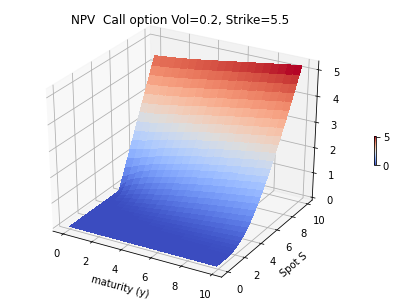

In [26]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(dt.numpy(), S.numpy(), npv.numpy(), rstride=5, cstride=3, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


fig.colorbar(surf, shrink=0.1, aspect=20)
plt.title('NPV  Call option Vol=0.2, Strike=5.5')
plt.ylabel("Spot S")
plt.xlabel("maturity (y)")

plt.show()

In [32]:
with tf.GradientTape() as g1:
    npv = BS_Call(S, K, dt, vol, r)
dv = g1.gradient(npv, S)  # first order derivatives

In [120]:

S = tf.range(0,10., 0.1, dtype=tf.float32)

dt = tf.range(0,10., 0.1, dtype=tf.float32)
dt = tf.expand_dims(dt, axis=-1)


K = tf.range(0,10., 0.1, dtype=tf.float32)
K = tf.expand_dims(K, axis=-1)
K = tf.expand_dims(K, axis=-1)

vol = tf.range(0,1., 0.1, dtype=tf.float32)
vol = tf.expand_dims(vol, axis=-1)
vol = tf.expand_dims(vol, axis=-1)
vol = tf.expand_dims(vol, axis=-1)

r = tf.range(0,0.1, 0.1, dtype=tf.float32)
r = tf.expand_dims(r, axis=-1)
r = tf.expand_dims(r, axis=-1)
r = tf.expand_dims(r, axis=-1)
r = tf.expand_dims(r, axis=-1)

In [121]:
K.shape

TensorShape([100, 1, 1])

In [122]:

npv = BS_Call(S, K, dt, vol, r)
npv

<tf.Tensor: shape=(1, 10, 100, 100, 100), dtype=float32, numpy=
array([[[[[           nan, 1.00000001e-01, 2.00000003e-01, ...,
           9.70000076e+00, 9.80000114e+00, 9.90000153e+00],
          [           nan, 1.00000001e-01, 2.00000003e-01, ...,
           9.70000076e+00, 9.80000114e+00, 9.90000153e+00],
          [           nan, 1.00000001e-01, 2.00000003e-01, ...,
           9.70000076e+00, 9.80000114e+00, 9.90000153e+00],
          ...,
          [           nan, 1.00000001e-01, 2.00000003e-01, ...,
           9.70000076e+00, 9.80000114e+00, 9.90000153e+00],
          [           nan, 1.00000001e-01, 2.00000003e-01, ...,
           9.70000076e+00, 9.80000114e+00, 9.90000153e+00],
          [           nan, 1.00000001e-01, 2.00000003e-01, ...,
           9.70000076e+00, 9.80000114e+00, 9.90000153e+00]],

         [[0.00000000e+00,            nan, 1.00000001e-01, ...,
           9.60000038e+00, 9.70000076e+00, 9.80000114e+00],
          [0.00000000e+00,            nan, 1.000000

In [123]:
%%timeit -n 1 -r 1
npv = BS_Call(S, K, dt, vol, r)

1 loop, best of 1: 1.76 ms per loop


In [124]:
%%timeit -n 1 -r 1
npv = BS_Call(S, K, dt, vol, r)


1 loop, best of 1: 1.99 ms per loop


In [143]:
%%timeit -n 1 -r 1
with tf.device('/device:cpu:0'):
  npv = BS_Call(S, K, dt, vol, r)

1 loop, best of 1: 81.6 ms per loop


In [126]:
%timeit
npv = BS_Call(S, K, dt, vol, r)
print((time.time() -st)*1000, "ms")

660309.6826076508 ms


In [ ]:
st = time.time()
npv = BS_Call(S, K, dt, vol, r)
print((time.time() -st)*1000, "ms")